Dataset: HuGaDB
https://github.com/romanchereshnev/HuGaDB/blob/master/README.md

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
#from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, preprocessing, pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import time
import os
from os.path import exists, isabs, basename, join, isdir
import zipfile
!pip install gdown==4.6.0
import gdown
!pip install shap --upgrade
import shap
from glob import glob
from sklearn.impute import SimpleImputer
import xgboost as xgb
import warnings
import sqlite3

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/3a/ee/f77fd0c99639579ec063b06b5ca310f2b9f496cedd8a4f633ac5d97a1473/shap-0.44.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.44.0
    Uninstalling shap-0.44.0:
      Successfully uninstalled shap-0.44.0


In [2]:
#Dataset from Google Drive

url = 'https://drive.google.com/uc?id=15zLaP5V3ltR6qro98u492eqFBSeSO-0m'
output = '/content/dataset/'
gdown.download(url, output, quiet=False)

extract_path = '/content/dataset/'

with zipfile.ZipFile('/content/dataset/HuGaDB v2.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)


os.remove('/content/dataset/HuGaDB v2.zip')


Downloading...
From: https://drive.google.com/uc?id=15zLaP5V3ltR6qro98u492eqFBSeSO-0m
To: /content/dataset/HuGaDB v2.zip
100%|██████████| 88.8M/88.8M [00:00<00:00, 163MB/s]


Parsing of the Datased suggested in https://github.com/romanchereshnev/HuGaDB/blob/master/README.md

In [3]:
def create_tables(dbname='HuGaDB.db'):
    """Create 'files' and 'data' tables in SQLite DB
       Parameters:
            dbname: string
                name of the SQLite database
        Return: bool
            False - if the database was already created
    """
    rows_type = "id INTEGER PRIMARY KEY, file_id INTEGER, timestamp INTEGER, " + \
                "acc_rf_x  INTEGER,  acc_rf_y INTEGER,  acc_rf_z INTEGER, gyro_rf_x INTEGER,  gyro_rf_y INTEGER,  gyro_rf_z INTEGER," + \
                "acc_rs_x INTEGER,  acc_rs_y INTEGER, acc_rs_z INTEGER, gyro_rs_x INTEGER, gyro_rs_y INTEGER, gyro_rs_z INTEGER, " +  \
                "acc_rt_x INTEGER,  acc_rt_y INTEGER, acc_rt_z INTEGER, gyro_rt_x INTEGER, gyro_rt_y INTEGER, gyro_rt_z INTEGER, " +  \
                "acc_lf_x INTEGER,  acc_lf_y INTEGER, acc_lf_z INTEGER, gyro_lf_x INTEGER, gyro_lf_y INTEGER, gyro_lf_z INTEGER, " +  \
                "acc_ls_x INTEGER,  acc_ls_y INTEGER, acc_ls_z INTEGER, gyro_ls_x INTEGER, gyro_ls_y INTEGER, gyro_ls_z INTEGER, " +   \
                "acc_lt_x INTEGER,  acc_lt_y INTEGER, acc_lt_z INTEGER, gyro_lt_x INTEGER, gyro_lt_y INTEGER, gyro_lt_z INTEGER, " +  \
                "EMG_r INTEGER, EMG_l INTEGER, act INTEGER"

    if not exists(dbname):
        con = sqlite3.connect(dbname)
        cur = con.cursor()
        cur.execute('CREATE TABLE files (id INTEGER PRIMARY KEY, filename VARCHAR(100))')
        con.commit()
        cur.execute('CREATE TABLE data (' + rows_type + ')')
        con.commit()
        con.close()
        return True
    else:
        return False

def add_file_to_db(filename, dbname='HuGaDB.db'):
    """Add data from HuGaDB file in SQLite table
       Parameters:
           filename: string
               path to HuGaDB
           dbname: string
               name of the SQLite database
        Return: bool
            False - if the database was already created
    """
    con = sqlite3.connect(dbname)
    cur = con.cursor()

    data = np.genfromtxt(filename, delimiter='\t', skip_header=4)

    if isabs(filename):
        filename = basename(filename)

    cur.execute("INSERT INTO files VALUES(NULL, '{0}')".format(filename))
    con.commit()
    row_id = cur.execute('SELECT id FROM files WHERE filename="{0}"'.format(filename)).fetchone()[0]
    con.commit()

    for i, row in enumerate(data):
        cur.execute("INSERT INTO data VALUES(NULL, {0}, {1}, ".format(row_id, i) +  str(tuple(row.tolist())).replace("(", ""))
    con.commit()
    con.close()

def create_db(path_to_HuGaDB_folder, dbname='HuGaDB.db'):
    """Creating SQLite database from HuGaDB text files
       Parameters:
           path_to_HuGaDB_folder: string
               path to the folder with HuGaDB
           dbname: string
               name of the SQLite database
    """
    if not isdir(path_to_HuGaDB_folder):
        print("No such folder " + path_to_HuGaDB_folder)
        return
    files = glob(join(path_to_HuGaDB_folder, 'HuGaDB*.txt'))
    length = len(files)
    if length == 0:
        print("No HuGaDB files in the folder")
        return

    if not create_tables(dbname=dbname):
        print("DB is already exist")
        return
    for i, filename in enumerate(files):
        #print(f"Creating database: file {i+1}/{length}")
        add_file_to_db(filename, dbname=dbname)


path_to_HuGaDB_folder = '/content/dataset/'


create_db(path_to_HuGaDB_folder=path_to_HuGaDB_folder)


In [4]:
conn = sqlite3.connect('HuGaDB.db')

query = 'SELECT * FROM data'

df = pd.read_sql_query(query, conn)

conn.close()

print(df)


              id  file_id  timestamp  acc_rf_x  acc_rf_y  acc_rf_z  gyro_rf_x  \
0              1        1          0       356    -17388     10292       9006   
1              2        1          1     -1512    -12332      7732      11391   
2              3        1          2     -4672    -10160      7884      11117   
3              4        1          3     -6492     -9060      7928       9595   
4              5        1          4     -8216     -8268      7080       6156   
...          ...      ...        ...       ...       ...       ...        ...   
1137981  1137982      364       2575     -9188     -3268     13600        110   
1137982  1137983      364       2576     -9136     -3216     13536         74   
1137983  1137984      364       2577     -9128     -3280     13528         97   
1137984  1137985      364       2578     -9180     -3252     13580        102   
1137985  1137986      364       2579     -9164     -3268     13516         97   

         gyro_rf_y  gyro_rf

In [5]:
df = df.dropna()
df = df.drop('id', axis=1)
df = df.drop('file_id', axis=1)
df = df.drop('timestamp', axis=1)
X = df.drop('act', axis=1)  # Features
#X = X.apply(pd.to_numeric, errors='coerce')
y = df['act']  # Labels

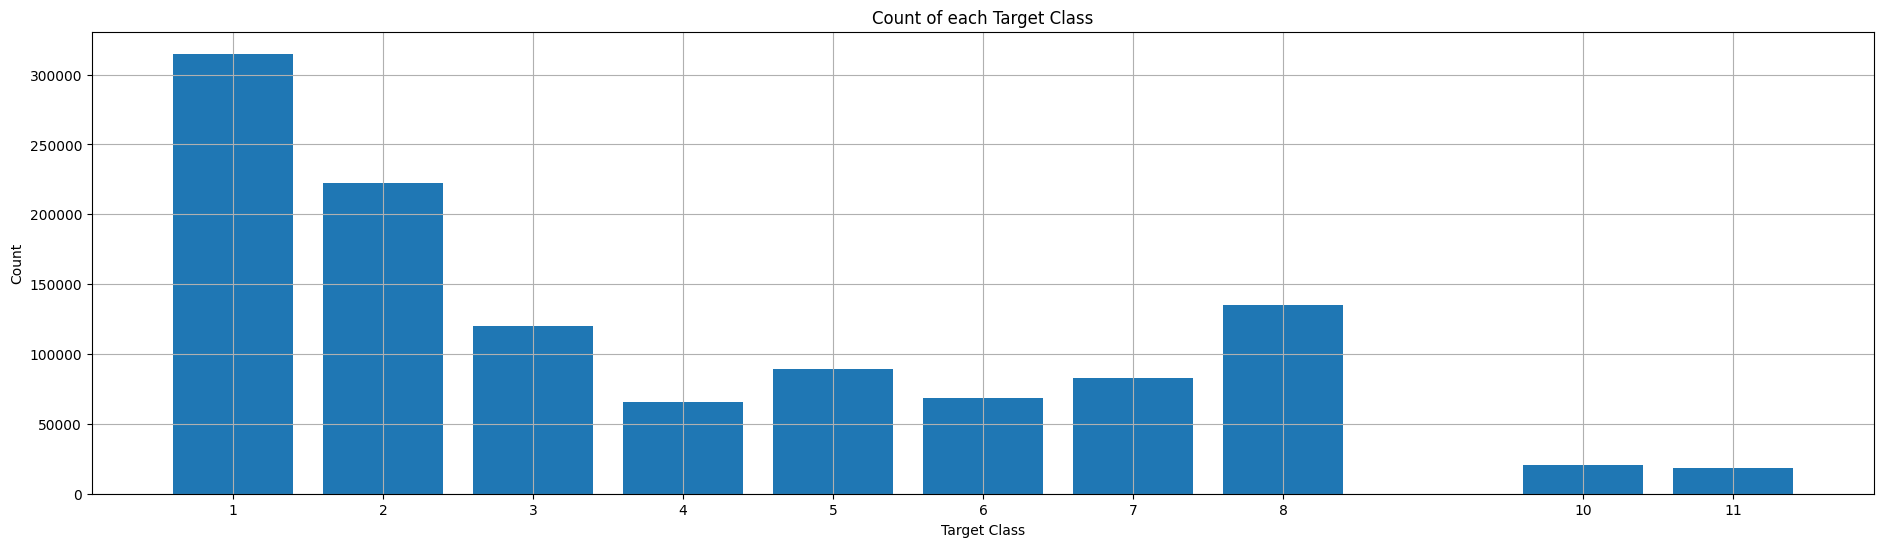

In [6]:
rcParams['figure.figsize'] = 23,6
plt.bar(df['act'].unique(), df['act'].value_counts())
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.xticks(df['act'].unique())
plt.title('Count of each Target Class')
plt.grid()
plt.savefig("target_class2.png")

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
unique_labels = np.unique(y_train)

print("Unique Labels:", unique_labels)
print(len(df.columns))

Unique Labels: [ 1  2  3  4  5  6  7  8 10 11]
39


In [9]:
#visualize the columns
df.columns

Index(['acc_rf_x', 'acc_rf_y', 'acc_rf_z', 'gyro_rf_x', 'gyro_rf_y',
       'gyro_rf_z', 'acc_rs_x', 'acc_rs_y', 'acc_rs_z', 'gyro_rs_x',
       'gyro_rs_y', 'gyro_rs_z', 'acc_rt_x', 'acc_rt_y', 'acc_rt_z',
       'gyro_rt_x', 'gyro_rt_y', 'gyro_rt_z', 'acc_lf_x', 'acc_lf_y',
       'acc_lf_z', 'gyro_lf_x', 'gyro_lf_y', 'gyro_lf_z', 'acc_ls_x',
       'acc_ls_y', 'acc_ls_z', 'gyro_ls_x', 'gyro_ls_y', 'gyro_ls_z',
       'acc_lt_x', 'acc_lt_y', 'acc_lt_z', 'gyro_lt_x', 'gyro_lt_y',
       'gyro_lt_z', 'EMG_r', 'EMG_l', 'act'],
      dtype='object')

In [10]:
#visualize the distribution of the target values in the dataset
y.value_counts()

act
1     314966
8     222649
3     135127
4     119819
10     89144
5      82819
11     68762
2      65917
7      20603
6      18180
Name: count, dtype: int64

Training Time (in seconds): 17.237333557
Accuracy: 0.8049543493352315
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     63045
           1       0.96      0.93      0.94     13193
           2       0.88      0.85      0.86     27161
           3       0.88      0.79      0.84     23982
           4       0.97      0.99      0.98     16442
           5       0.91      0.89      0.90      3689
           6       0.94      0.86      0.90      4152
           7       0.62      0.95      0.75     44426
           8       0.55      0.20      0.30     17737
           9       0.60      0.09      0.15     13771

    accuracy                           0.80    227598
   macro avg       0.82      0.75      0.75    227598
weighted avg       0.80      0.80      0.78    227598



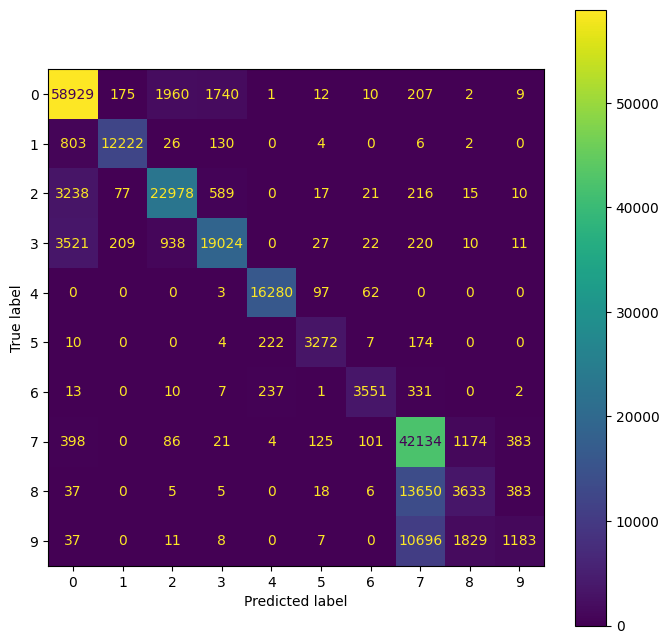

In [11]:
start = time.process_time()

#Use LabelEncoder to transform target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

#Create an XGBoost classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, objective='multi:softmax',
                            num_class=len(set(y_train_encoded)), random_state=42, tree_method='hist', device='cuda')

#Create a pipeline with preprocessing and XGBoost
pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler(), xgb_clf)
pipe.fit(X_train, y_train_encoded)  #apply scaling on training data
y_pred_encoded = pipe.predict(X_test)

#Transform predictions back to original classes
y_pred = label_encoder.inverse_transform(y_pred_encoded)

end = time.process_time()
print("Training Time (in seconds):", end - start)

y_test_encoded = label_encoder.transform(y_test)

#Confusion matrix
f, ax = plt.subplots(1, 1, figsize=(8, 8))
disp = metrics.ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test_encoded, ax=ax)

#Visualize the metrics of the model
print("Accuracy:", metrics.accuracy_score(y_test_encoded, y_pred_encoded))
print("Classification Report:")
print(metrics.classification_report(y_test_encoded, y_pred_encoded))

disp.figure_.savefig("xgb_conf.png")

In [12]:
background_data_summary = shap.sample(X_train, 10)


feature_names = X_train.columns.tolist()

#Create a wrapper function for prediction without feature names
predict_function = lambda x: pipe.predict(x)

#Use the wrapper function in the explainer
explainer = shap.KernelExplainer(predict_function, background_data_summary, feature_names=feature_names, approximate=True)

#Downsample X_test consistently for both SHAP computation and summary plot
downsampled_X_test = X_test.sample(frac=0.01, random_state=42)

#Ensure the downsampled data has the same columns and order as the training data
downsampled_X_test = downsampled_X_test[X_train.columns]

#Check for missing values in the downsampled data
if downsampled_X_test.isnull().values.any():
    raise ValueError("Downsampled data contains missing values. Handle them before computing SHAP values.")

#Compute SHAP values for the downsampled X_test
shap_values = explainer.shap_values(downsampled_X_test)


  0%|          | 0/2276 [00:00<?, ?it/s]

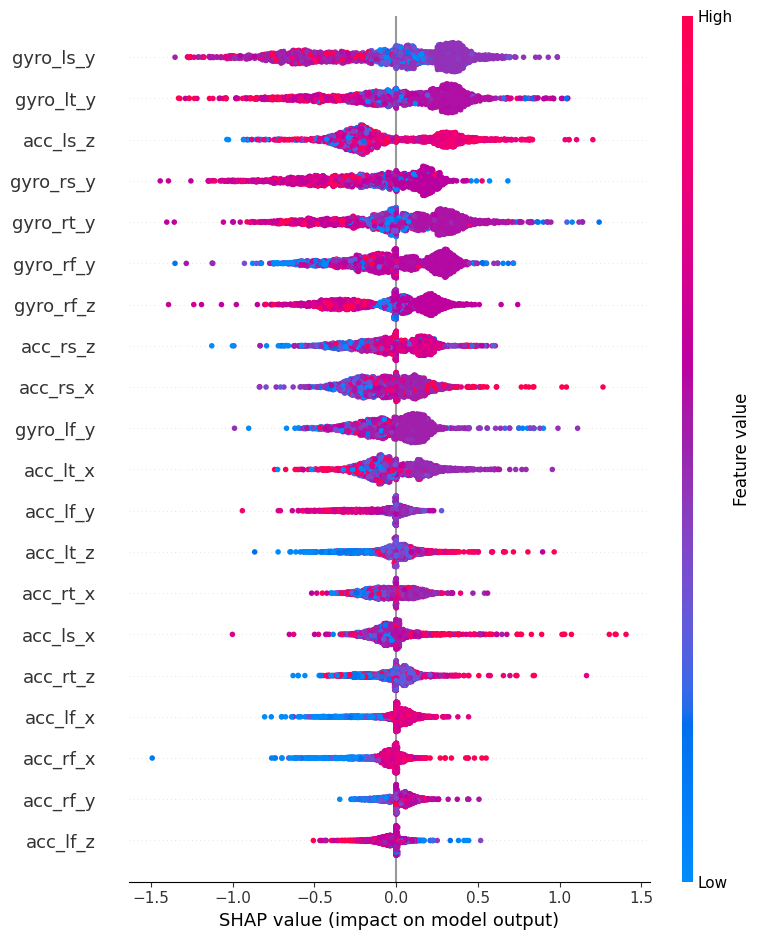

In [13]:
shap.summary_plot(shap_values, downsampled_X_test)

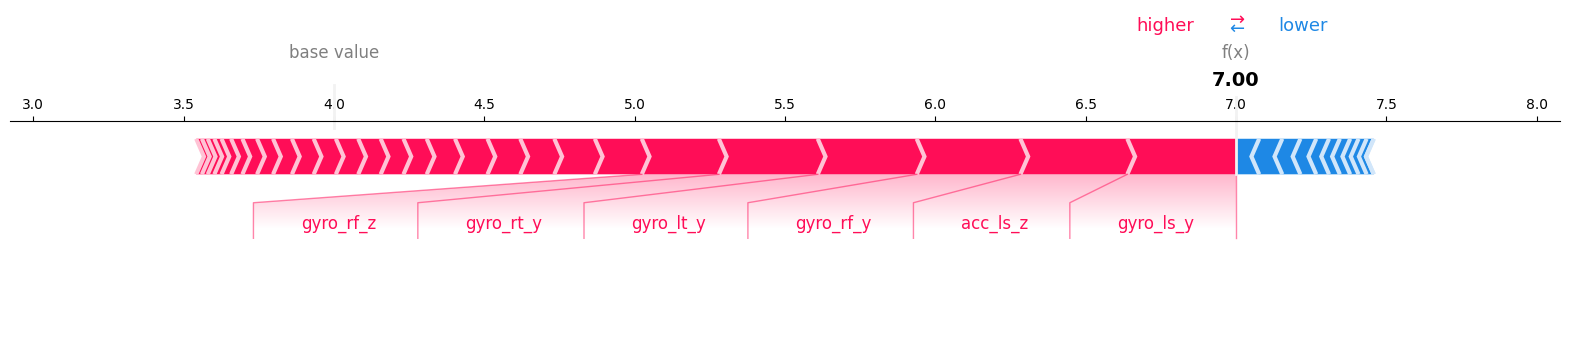

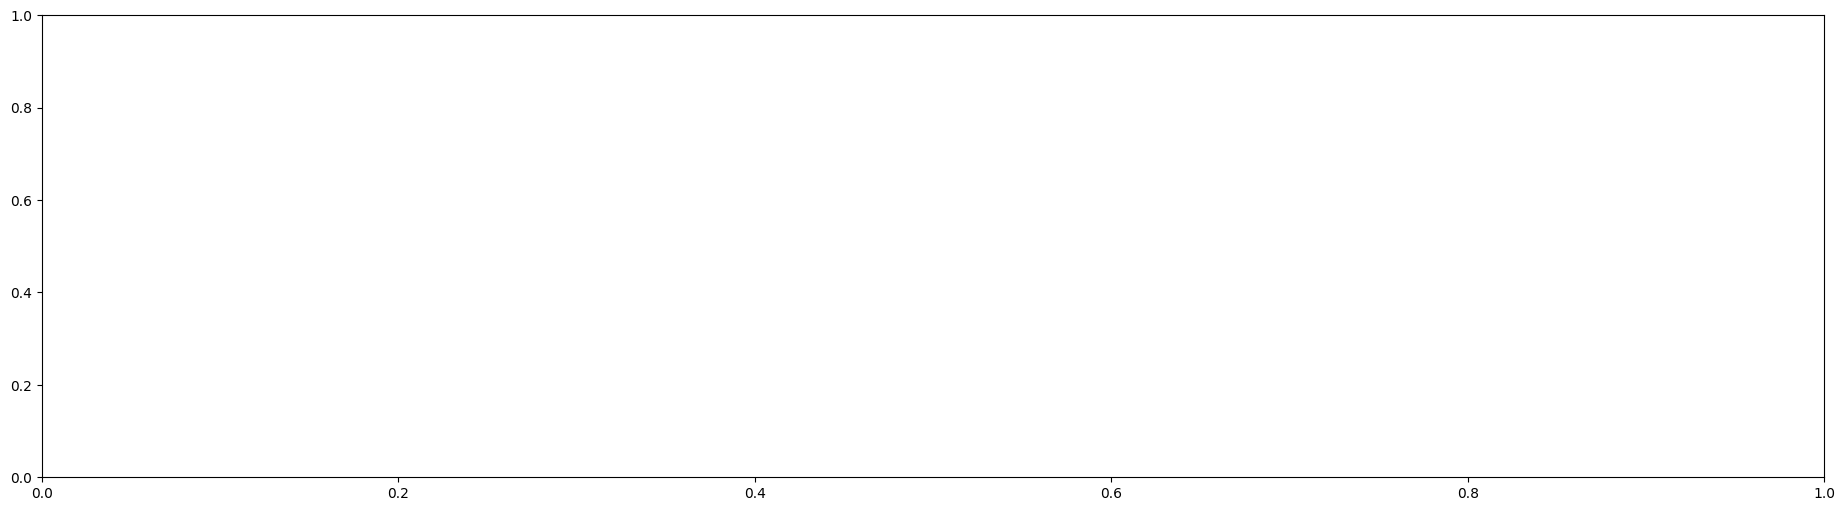

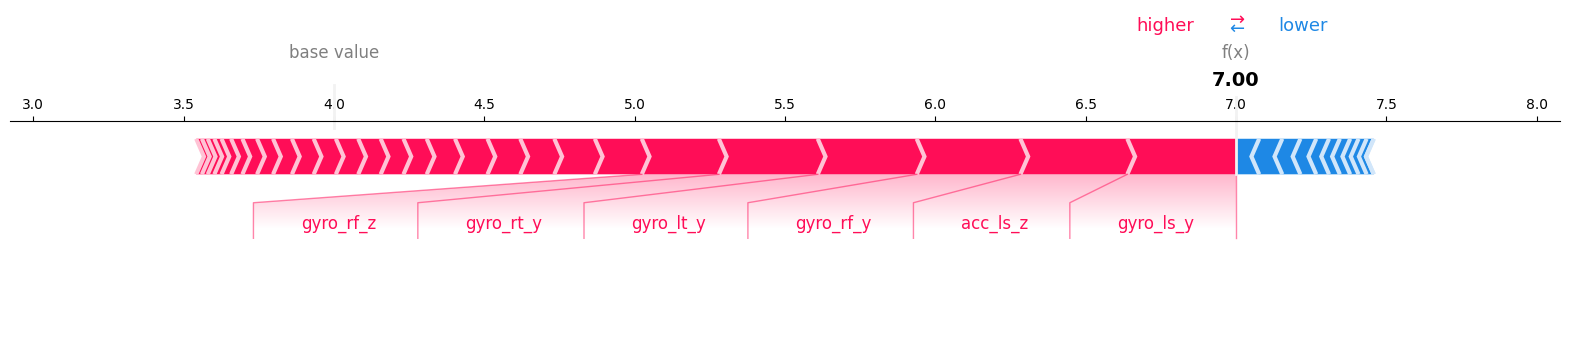

In [14]:
shap.initjs()
fig, ax = plt.subplots()
force_plot = shap.force_plot(explainer.expected_value, shap_values[29], feature_names=feature_names, matplotlib=True, show=False)
fig.savefig('force_plot.png', bbox_inches='tight')
force_plot

These next 2 pieces of code automatically seperates the features for leader and follower according to the shapley values of each feature based on a threshold given by us.

In [15]:
#taking the average of Shap values
shaps = np.mean(shap_values, axis=0)
shaps

array([-6.17173148e-02,  2.28174185e-02, -1.61633297e-02,  1.09885062e-03,
       -1.32320835e-02, -4.85768269e-02, -4.96013623e-02, -3.09859391e-03,
       -2.95040095e-02, -4.48245891e-04, -1.39157640e-01, -3.92562095e-05,
       -2.49574461e-02, -4.29640814e-03, -2.78468654e-03, -3.57229372e-03,
        3.10060250e-02, -1.23600242e-02, -4.17616126e-03, -7.28660971e-02,
       -4.14205404e-02,  1.14042861e-03, -1.70305711e-02, -1.31633593e-03,
       -2.57167362e-02,  1.12899624e-03, -5.40283869e-02, -4.95648178e-04,
       -7.47544201e-02, -9.44675257e-03, -1.60053152e-02,  5.99909521e-03,
       -8.93868714e-03, -2.87700676e-03,  3.64935042e-02, -1.61930970e-02,
       -2.11055791e-03,  3.47386762e-04])

In [16]:
#Divide features into 2 sets according to a threshold value based on average shap values
column_names = X.columns
fset_1 = pd.DataFrame()
fset_2 = pd.DataFrame()
threshold = 0

for feature, shap_value in zip(column_names, shaps):
    if shap_value > threshold:
      fset_1[feature] = X[feature]
    if shap_value <= threshold:
      fset_2[feature] = X[feature]

In [17]:
all_features = ['acc_rf_x', 'acc_rf_y', 'acc_rf_z', 'gyro_rf_x', 'gyro_rf_y',
                'gyro_rf_z', 'acc_rs_x', 'acc_rs_y', 'acc_rs_z', 'gyro_rs_x',
                'gyro_rs_y', 'gyro_rs_z', 'acc_rt_x', 'acc_rt_y', 'acc_rt_z',
                'gyro_rt_x', 'gyro_rt_y', 'gyro_rt_z', 'acc_lf_x', 'acc_lf_y',
                'acc_lf_z', 'gyro_lf_x', 'gyro_lf_y', 'gyro_lf_z', 'acc_ls_x',
                'acc_ls_y', 'acc_ls_z', 'gyro_ls_x', 'gyro_ls_y', 'gyro_ls_z',
                'acc_lt_x', 'acc_lt_y', 'acc_lt_z', 'gyro_lt_x', 'gyro_lt_y',
                'gyro_lt_z', 'EMG_r', 'EMG_l', 'act']

#Specify the features used by the leader
leader_features = ['gyro_ls_y', 'acc_rs_z', 'gyro_rs_y', 'gyro_rt_y', 'gyro_lt_y',
                   'gyro_rf_z', 'acc_rs_x', 'acc_rt_x', 'gyro_rf_y', 'gyro_lf_y',
                   'acc_lt_x', 'acc_ls_z', 'acc_ls_x', 'gyro_lf_z','acc_rf_y',
                   'acc_lf_x','acc_lf_y','acc_rf_x','acc_rt_z', 'acc_lt_z']

num_classes = 10

follower_features = ['acc_rf_z', 'gyro_rf_x', 'acc_rs_y', 'gyro_rs_x', 'gyro_rs_z',
                     'acc_rt_y', 'gyro_rt_x', 'gyro_rt_z', 'acc_lf_z', 'gyro_lf_x',
                     'acc_ls_y', 'gyro_ls_x', 'gyro_ls_z', 'acc_lt_y', 'gyro_lt_x',
                     'gyro_lt_z', 'EMG_r', 'EMG_l']



leader_data = df[leader_features + ['act']].copy()
#leader_data_no_label = df[leader_features].copy()
leader_data_no_label = fset_1.copy()

#Split leader into training and testing sets
#leader_train, leader_test = train_test_split(leader_data, test_size=0.2, random_state=42)
X_leader_train, X_leader_test, y_leader_train, y_leader_test = train_test_split(fset_1, y, test_size=0.2, random_state=42)

#Separate features and labels for leader
#X_leader_train = leader_train[leader_features]
#y_leader_train = leader_train['act']
#X_leader_test = leader_test[leader_features]
#y_leader_test = leader_test['act']

#Check if unique classes match the expected classes
expected_classes = list(range(num_classes))  # Assuming num_classes is the expected number of classes
if set(y_leader_train.unique()) != set(expected_classes):
    # If not, re-map the classes to match the expected classes
    class_mapping = {cls: idx for idx, cls in enumerate(y_leader_train.unique())}
    y_leader_train = y_leader_train.map(class_mapping)
    y_leader_test = y_leader_test.map(class_mapping)

#Train XGBoost model for leader using only the specified features
leader_model = xgb.XGBClassifier(
    learning_rate=0.1, n_estimators=100, max_depth=3, objective='multi:softmax',
    num_class=len(set(y_leader_train)), random_state=42, tree_method='hist', device='cuda'
)


leader_model.fit(X_leader_train, y_leader_train)

#Make predictions using the leader's model for the leader's test set
leader_predictions_test = leader_model.predict(X_leader_test)
leader_predictions = leader_model.predict(leader_data_no_label)          #new column of predictions for the follower model
#Evaluate the leader's accuracy
accuracy_leader = accuracy_score(y_leader_test, leader_predictions_test)
print(f'Leader Accuracy: {accuracy_leader}')

Leader Accuracy: 0.5935992407666149


In [18]:
print(len(all_features))
print(len(leader_features))
print(len(follower_features))
print(len(fset_1.columns))
print(len(fset_2.columns))

39
20
18
8
30


In [19]:
follower_data = df[follower_features + ['act']].copy()
follower_data['predicted_leader'] = leader_predictions         #now the follower data contains the features that leader did not use + predictions of the leader

follower_features = ['acc_rf_x', 'acc_rf_y', 'acc_rf_z', 'gyro_rf_x',
                  'acc_rs_y',  'gyro_rs_x',
                 'gyro_rs_z',  'acc_rt_y', 'acc_rt_z',
                'gyro_rt_x',  'gyro_rt_z', 'acc_lf_x', 'acc_lf_y',
                'acc_lf_z', 'gyro_lf_x', 'gyro_lf_z', 'acc_ls_x',
                'acc_ls_y', 'acc_ls_z', 'gyro_ls_x', 'gyro_ls_z',
                'acc_lt_x', 'acc_lt_y', 'acc_lt_z', 'gyro_lt_x',
                'gyro_lt_z', 'EMG_r', 'EMG_l','predicted_leader'] #new feature (predicted_leader)

#SAME PROCEDURE FOLLOWED ALSO FOR THE LEADER, ONLY THE FEATURES CHANGE


#follower_train, follower_test = train_test_split(follower_data, test_size=0.2, random_state=42)
fset_2['predicted_leader'] = leader_predictions
X_follower_train, X_follower_test, y_follower_train, y_follower_test = train_test_split(fset_2, y, test_size=0.2, random_state=42)

#Separate features and labels for follower
#X_follower_train = follower_train[follower_features]
#y_follower_train = follower_train['act']
#X_follower_test = follower_test[follower_features]
#y_follower_test = follower_test['act']

#Check if unique classes match the expected classes
expected_classes = list(range(num_classes))
if set(y_follower_train.unique()) != set(expected_classes):
    #If not, re-map the classes to match the expected classes
    class_mapping = {cls: idx for idx, cls in enumerate(y_follower_train.unique())}
    y_follower_train = y_follower_train.map(class_mapping)
    y_follower_test = y_follower_test.map(class_mapping)

#Train XGBoost model for follower using only the specified features
follower_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, objective='multi:softmax',
    num_class=len(set(y_train)), random_state=42, tree_method='hist', device='cuda')


follower_model.fit(X_follower_train, y_follower_train)

#Make predictions using the follower's model for the follower's test set
follower_predictions_test = follower_model.predict(X_follower_test)

#Evaluate the follower's accuracy
accuracy_follower = accuracy_score(y_follower_test, follower_predictions_test)
print(f'Follower Accuracy: {accuracy_follower}')

Follower Accuracy: 0.7974762519881545
